# Speech Emotion Recognition (TESS dataset)

In [1]:
import pandas as pd 
import numpy as np
import os
import seaborn as sns 
import matplotlib.pyplot as plt
import librosa
import IPython.display as ipd
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
import warnings
warnings.filterwarnings('ignore')

## Load Data

In [2]:
def load_data(location: str):
    path = []
    labels = []
    for dirname, _, filenames in os.walk(location):
        for filename in filenames:
            path.append(os.path.join(dirname,filename))
            label = filename.split('_')[-1]
            label = label.split('.')[0]
            labels.append(label.lower())
    df = pd.DataFrame() 
    df['File'] = path
    df['Label'] = labels
    return df

In [3]:
df = load_data('./Data/')

In [53]:
df

File  Label
0     ./Data/TESS Toronto emotional speech set data\...  angry
1     ./Data/TESS Toronto emotional speech set data\...  angry
2     ./Data/TESS Toronto emotional speech set data\...  angry
3     ./Data/TESS Toronto emotional speech set data\...  angry
4     ./Data/TESS Toronto emotional speech set data\...  angry
...                                                 ...    ...
2795  ./Data/TESS Toronto emotional speech set data\...    sad
2796  ./Data/TESS Toronto emotional speech set data\...    sad
2797  ./Data/TESS Toronto emotional speech set data\...    sad
2798  ./Data/TESS Toronto emotional speech set data\...    sad
2799  ./Data/TESS Toronto emotional speech set data\...    sad

[2800 rows x 2 columns]

In [55]:
df['Label'].value_counts()

Label
angry      400
disgust    400
fear       400
happy      400
neutral    400
ps         400
sad        400
Name: count, dtype: int64

## Exploration data

<Axes: xlabel='Label', ylabel='count'>

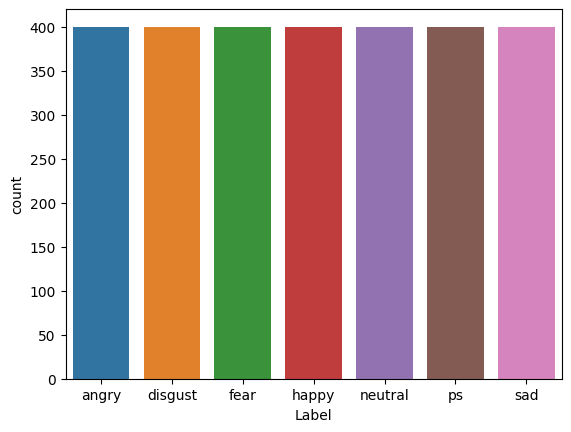

In [57]:
sns.countplot(df, x='Label')

In [68]:
def waveplot(data, sampling_rate, emotion):
    plt.figure(figsize=(10,4))
    plt.title(emotion, size=15)
    librosa.display.waveshow(data, sr=sampling_rate)
    plt.show()

In [97]:
def spectogram(data, sampling_rate, emotion):
    x = librosa.stft(data)
    xdb = librosa.amplitude_to_db(abs(x))
    plt.figure(figsize=(10,4))
    plt.title(emotion)
    librosa.display.specshow(xdb, sr=sampling_rate, x_axis='time', y_axis='hz')
    plt.colorbar()

In [123]:
def plot_waveplot_and_spectogram_with_audio(df,emotion: str):
    path = np.array(df['File'][df['Label'] == emotion])[0]
    data, sampling_rate = librosa.load(path)
    waveplot(data, sampling_rate, emotion)
    spectogram(data, sampling_rate, emotion)
    ipd.Audio(path)

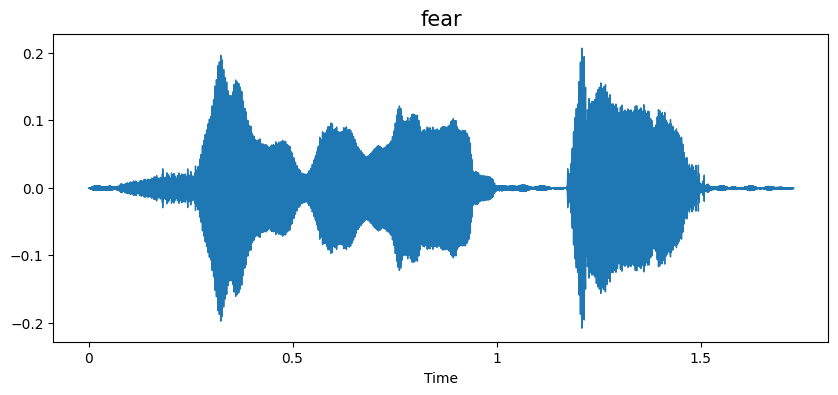

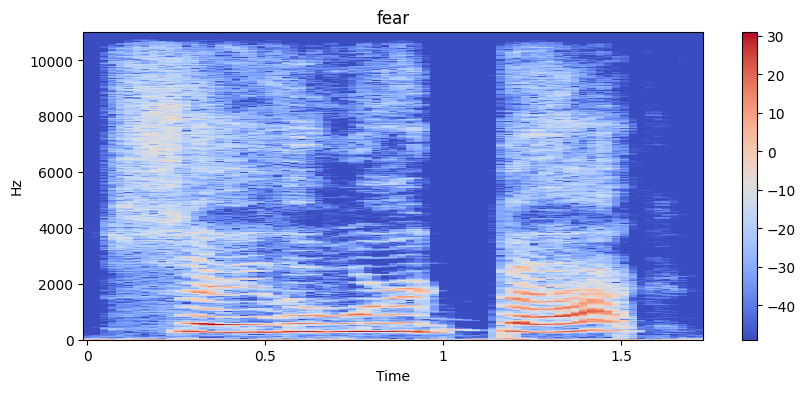

In [124]:
plot_waveplot_and_spectogram_with_audio(df,'fear')

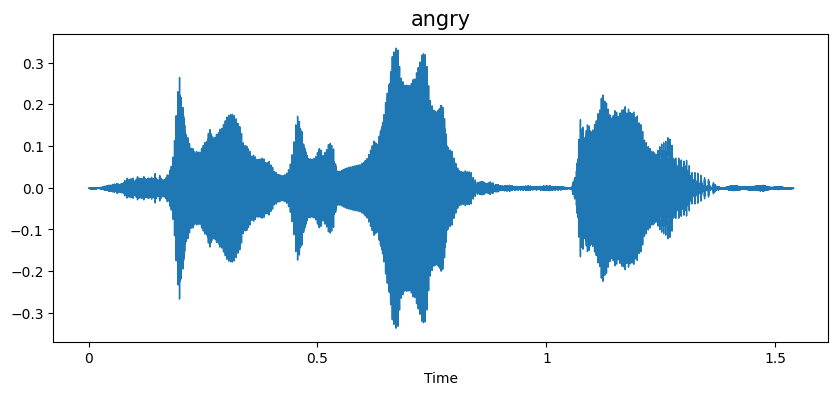

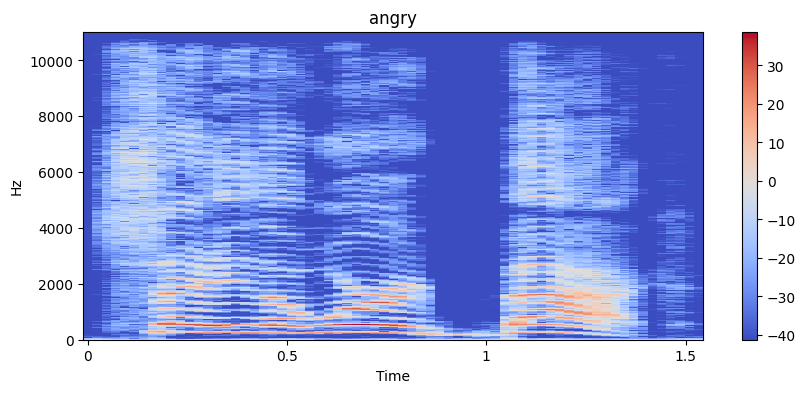

In [100]:
plot_waveplot_and_spectogram_with_audio(df,'angry')

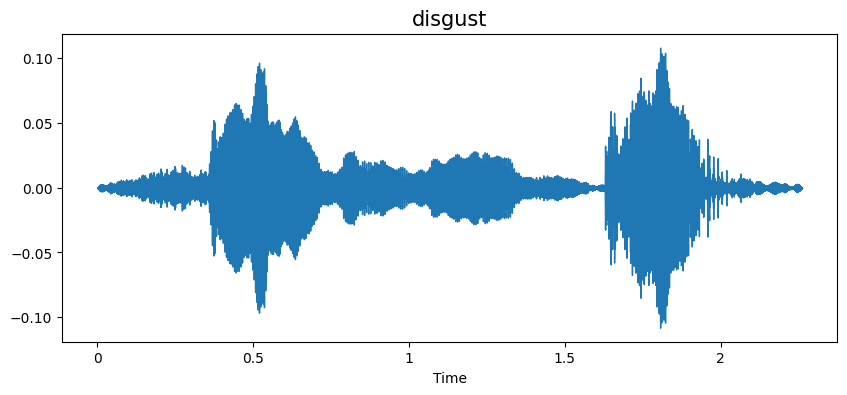

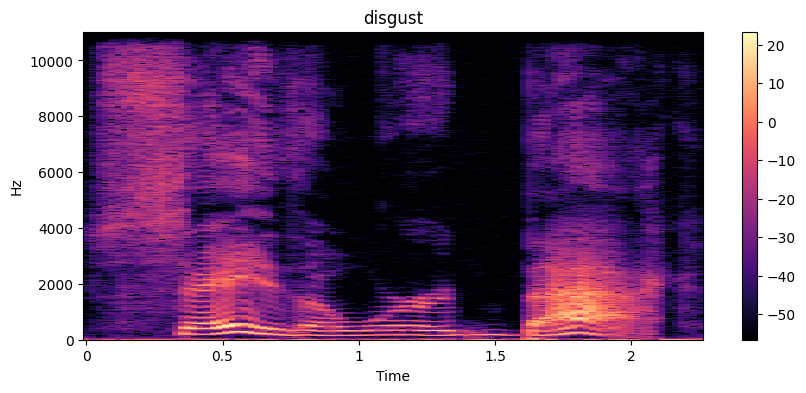

In [101]:
plot_waveplot_and_spectogram_with_audio(df,'disgust')

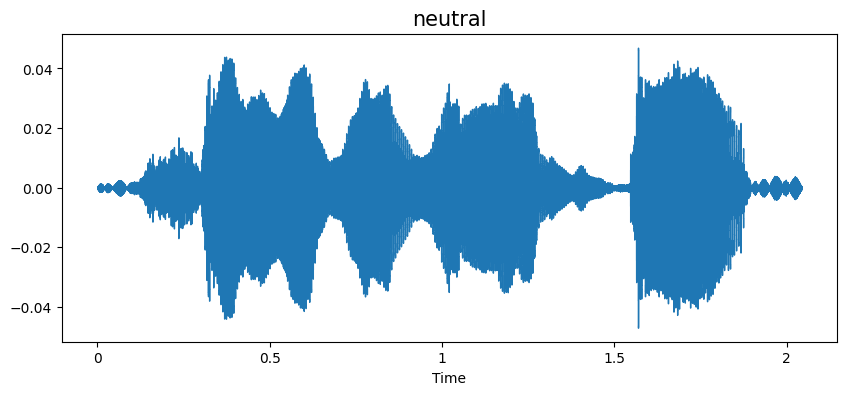

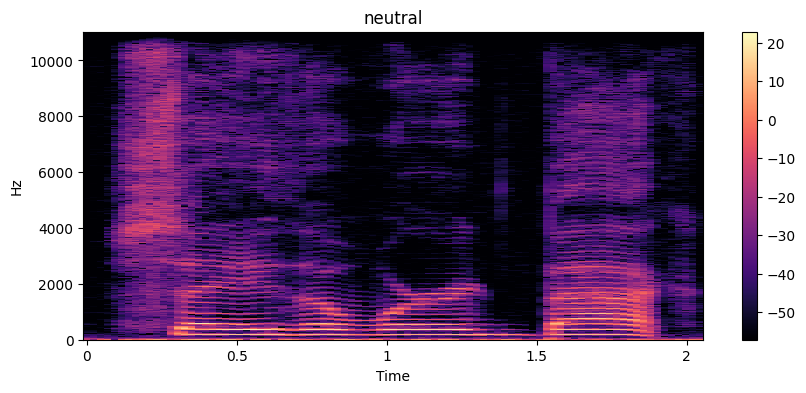

In [102]:
plot_waveplot_and_spectogram_with_audio(df,'neutral')

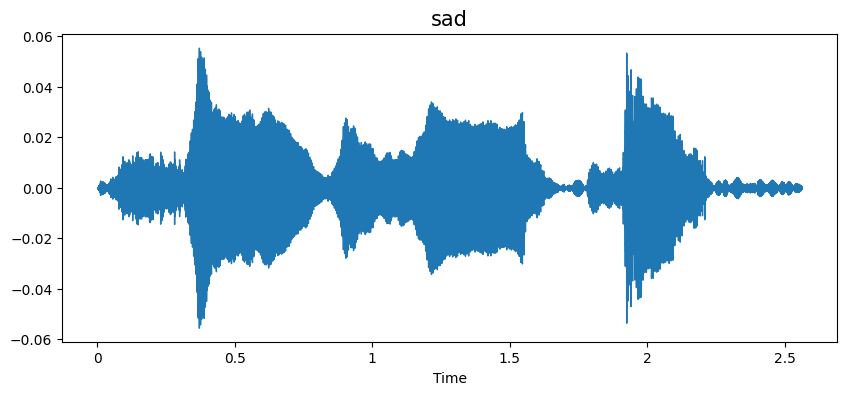

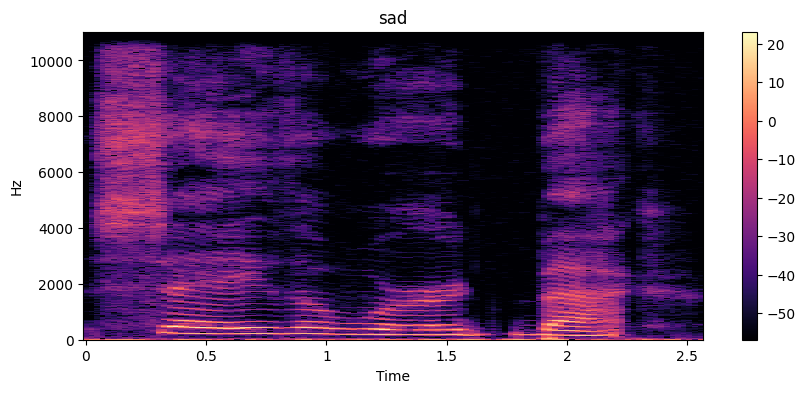

In [103]:
plot_waveplot_and_spectogram_with_audio(df,'sad')

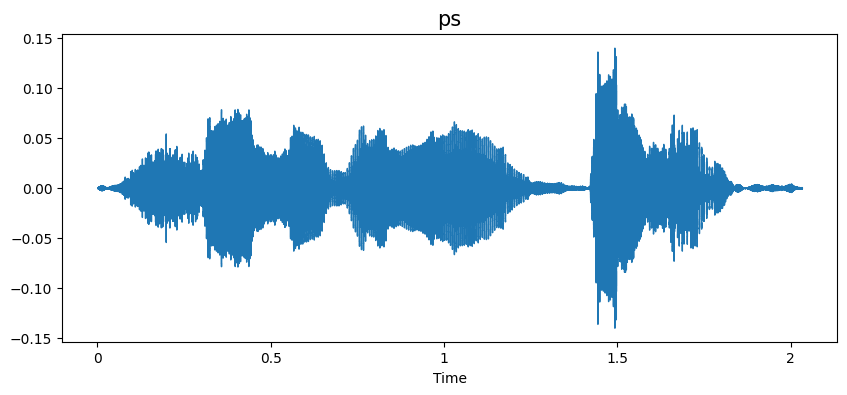

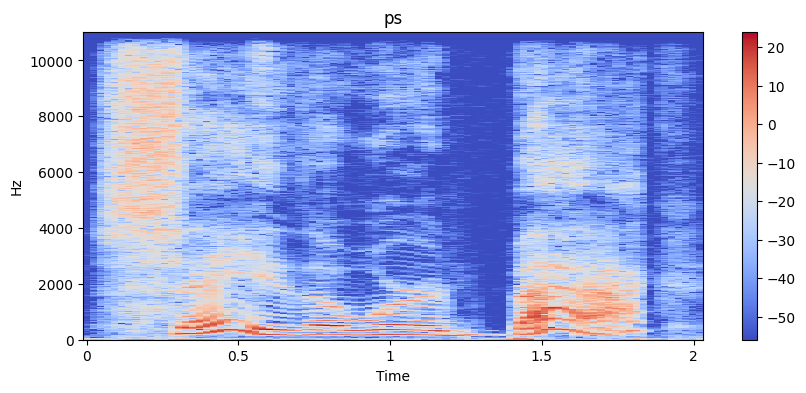

In [104]:
plot_waveplot_and_spectogram_with_audio(df,'ps')

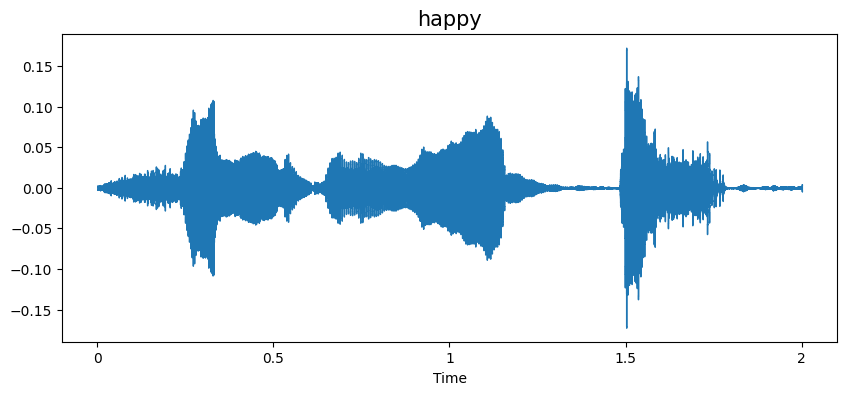

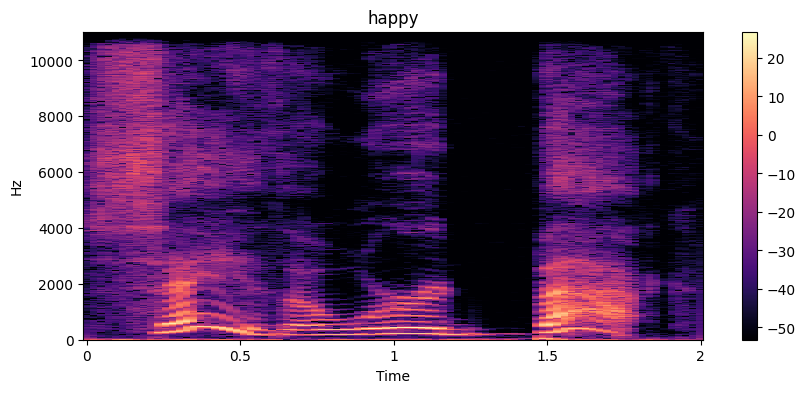

In [105]:
plot_waveplot_and_spectogram_with_audio(df,'happy')

## Feature Extraction

In [4]:
def extract_mfcc(filename):
    y, sampling_rate = librosa.load(filename, duration=3, offset=0.5)
    mfcc = np.mean(librosa.feature.mfcc(y=y,sr=sampling_rate,n_mfcc=40).T,axis=0)
    return mfcc

In [5]:
X_mfcc = df['File'].apply(lambda x: extract_mfcc(x))

In [6]:
X_mfcc

0       [-396.9862, 77.44054, -19.59279, -21.666689, -...
1       [-465.73267, 98.77373, 0.65600884, -32.74544, ...
2       [-429.79196, 46.124, 1.5550473, -0.21709493, 2...
3       [-403.46118, 76.32369, -12.531774, -22.288858,...
4       [-434.05756, 77.4455, 10.8655, 16.092943, 8.04...
                              ...                        
2795    [-406.48053, 80.379875, 32.462395, 46.579094, ...
2796    [-426.90918, 102.54757, 24.800041, 43.048096, ...
2797    [-378.50494, 80.91062, 35.300533, 39.74792, -4...
2798    [-434.8618, 89.90637, 28.373262, 39.57707, -2....
2799    [-421.8341, 70.69788, 32.476387, 45.642555, 4....
Name: File, Length: 2800, dtype: object

In [7]:
X = [x for x in X_mfcc]
X = np.array(X)
X.shape

(2800, 40)

In [8]:
X = np.expand_dims(X,-1)
X.shape

(2800, 40, 1)

In [9]:
lb = LabelEncoder()

In [10]:
y = tf.keras.utils.to_categorical(lb.fit_transform(df[['Label']]))

In [11]:
y_train = np.array(y)

In [12]:
y_train.shape

(2800, 7)

## Create the LSTM Model

In [204]:
lstm_model = tf.keras.Sequential([
    tf.keras.layers.LSTM(256, return_sequences='False', input_shape=(40,1)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(7, activation='softmax')
])

In [205]:
lstm_model.compile(
    loss = 'categorical_crossentropy',
    optimizer = 'adam',
    metrics = ['accuracy']
)

In [206]:
lstm_model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_7 (LSTM)               (None, 40, 256)           264192    
                                                                 
 dropout_20 (Dropout)        (None, 40, 256)           0         
                                                                 
 dense_19 (Dense)            (None, 40, 128)           32896     
                                                                 
 dropout_21 (Dropout)        (None, 40, 128)           0         
                                                                 
 dense_20 (Dense)            (None, 40, 64)            8256      
                                                                 
 dropout_22 (Dropout)        (None, 40, 64)            0         
                                                                 
 flatten (Flatten)           (None, 2560)             

In [207]:
history = lstm_model.fit(X, y_train, validation_split=0.2, epochs=50)

Epoch 1/50
70/70 [==============================] - 9s 79ms/step - loss: 0.4789 - accuracy: 0.8152 - val_loss: 5.3047 - val_accuracy: 0.2875
Epoch 2/50
70/70 [==============================] - 5s 75ms/step - loss: 0.1147 - accuracy: 0.9625 - val_loss: 3.8778 - val_accuracy: 0.3161
Epoch 3/50
70/70 [==============================] - 5s 67ms/step - loss: 0.0677 - accuracy: 0.9804 - val_loss: 4.2158 - val_accuracy: 0.3661
Epoch 4/50
70/70 [==============================] - 5s 67ms/step - loss: 0.0487 - accuracy: 0.9835 - val_loss: 4.2999 - val_accuracy: 0.3286
Epoch 5/50
70/70 [==============================] - 5s 67ms/step - loss: 0.0367 - accuracy: 0.9844 - val_loss: 4.7816 - val_accuracy: 0.3268
Epoch 6/50
70/70 [==============================] - 5s 68ms/step - loss: 0.0306 - accuracy: 0.9902 - val_loss: 4.8376 - val_accuracy: 0.3946
Epoch 7/50
70/70 [==============================] - 5s 68ms/step - loss: 0.0303 - accuracy: 0.9884 - val_loss: 4.4935 - val_accuracy: 0.3643
Epoch 8/50
70

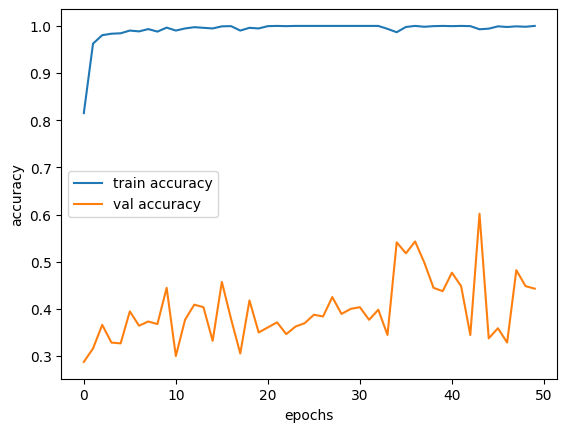

In [209]:
plt.plot(history.history['accuracy'], label='train accuracy')
plt.plot(history.history['val_accuracy'], label='val accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()
plt.show()

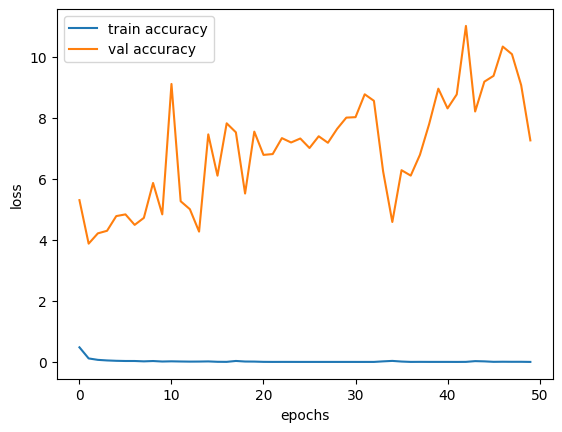

In [210]:
plt.plot(history.history['loss'], label='train accuracy')
plt.plot(history.history['val_loss'], label='val accuracy')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

## Create CNN Model

In [26]:
cnn_model = tf.keras.Sequential([
    tf.keras.layers.Conv1D(256,8,activation='relu',padding='same',input_shape=(X.shape[1],1)),
    tf.keras.layers.Conv1D(256,8,activation='relu',padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Conv1D(128,8,activation='relu',padding='same'),
    tf.keras.layers.Conv1D(128,8,activation='relu',padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64,activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(7,activation='softmax')
])

In [27]:
cnn_model.compile(
    loss = 'categorical_crossentropy',
    optimizer = 'adam',
    metrics = ['accuracy']
)

In [28]:
cnn_model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_25 (Conv1D)          (None, 40, 256)           2304      
                                                                 
 conv1d_26 (Conv1D)          (None, 40, 256)           524544    
                                                                 
 batch_normalization (BatchN  (None, 40, 256)          1024      
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 40, 256)           0         
                                                                 
 dropout_18 (Dropout)        (None, 40, 256)           0         
                                                                 
 conv1d_27 (Conv1D)          (None, 40, 128)           262272    
                                                      

In [29]:
history_cnn = cnn_model.fit(X,y_train,validation_split=0.2, epochs=50)

Epoch 1/50
70/70 [==============================] - 8s 99ms/step - loss: 1.6039 - accuracy: 0.3540 - val_loss: 2.2589 - val_accuracy: 0.2857
Epoch 2/50
70/70 [==============================] - 7s 97ms/step - loss: 0.9996 - accuracy: 0.6000 - val_loss: 3.0312 - val_accuracy: 0.3000
Epoch 3/50
70/70 [==============================] - 7s 101ms/step - loss: 0.7086 - accuracy: 0.7317 - val_loss: 2.6769 - val_accuracy: 0.2911
Epoch 4/50
70/70 [==============================] - 7s 97ms/step - loss: 0.4909 - accuracy: 0.8357 - val_loss: 2.1527 - val_accuracy: 0.3696
Epoch 5/50
70/70 [==============================] - 7s 101ms/step - loss: 0.3285 - accuracy: 0.8924 - val_loss: 2.1985 - val_accuracy: 0.4625
Epoch 6/50
70/70 [==============================] - 7s 100ms/step - loss: 0.2621 - accuracy: 0.9174 - val_loss: 3.7942 - val_accuracy: 0.3518
Epoch 7/50
70/70 [==============================] - 7s 97ms/step - loss: 0.2296 - accuracy: 0.9201 - val_loss: 3.2955 - val_accuracy: 0.4464
Epoch 8/50

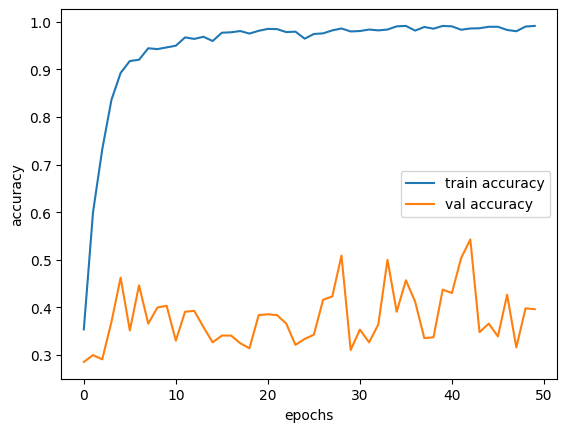

In [30]:
plt.plot(history_cnn.history['accuracy'], label='train accuracy')
plt.plot(history_cnn.history['val_accuracy'], label='val accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()
plt.show()

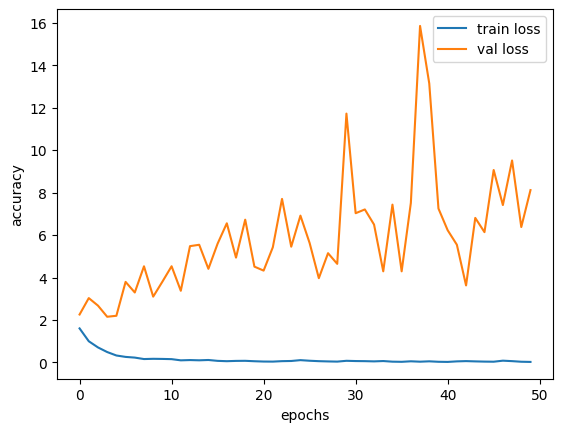

In [41]:
plt.plot(history_cnn.history['loss'], label='train loss')
plt.plot(history_cnn.history['val_loss'], label='val loss')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()
plt.show()

## LSTM 2 model

In [33]:
lstm_model_2 = tf.keras.Sequential([
    tf.keras.layers.LSTM(256, return_sequences='True', input_shape=(40,1)),
    tf.keras.layers.LSTM(256),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(7, activation='softmax')
])

In [34]:
lstm_model_2.compile(
    loss = 'categorical_crossentropy',
    optimizer = 'adam',
    metrics = ['accuracy']
)

In [35]:
history_lstm = lstm_model_2.fit(X,y_train,validation_split=0.2,epochs=50)

Epoch 1/50
70/70 [==============================] - 19s 238ms/step - loss: 0.8430 - accuracy: 0.7018 - val_loss: 1.9780 - val_accuracy: 0.4696
Epoch 2/50
70/70 [==============================] - 15s 214ms/step - loss: 0.3296 - accuracy: 0.9013 - val_loss: 1.6261 - val_accuracy: 0.5679
Epoch 3/50
70/70 [==============================] - 13s 187ms/step - loss: 0.2151 - accuracy: 0.9348 - val_loss: 2.4705 - val_accuracy: 0.4536
Epoch 4/50
70/70 [==============================] - 12s 172ms/step - loss: 0.1298 - accuracy: 0.9634 - val_loss: 3.4373 - val_accuracy: 0.3125
Epoch 5/50
70/70 [==============================] - 12s 174ms/step - loss: 0.1134 - accuracy: 0.9688 - val_loss: 2.0895 - val_accuracy: 0.6143
Epoch 6/50
70/70 [==============================] - 12s 178ms/step - loss: 0.1659 - accuracy: 0.9522 - val_loss: 3.3919 - val_accuracy: 0.3946
Epoch 7/50
70/70 [==============================] - 12s 165ms/step - loss: 0.1035 - accuracy: 0.9710 - val_loss: 3.7824 - val_accuracy: 0.3143

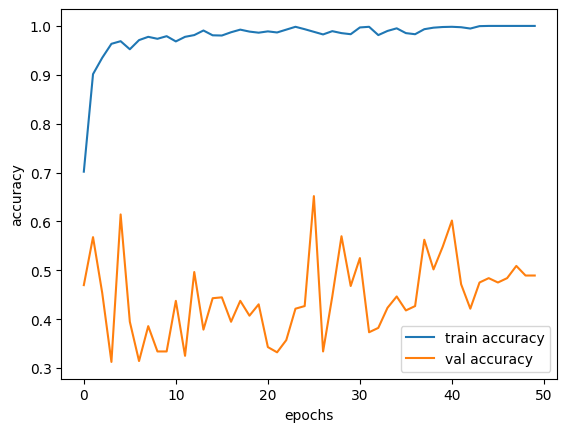

In [36]:
plt.plot(history_lstm.history['accuracy'], label='train accuracy')
plt.plot(history_lstm.history['val_accuracy'], label='val accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()
plt.show()

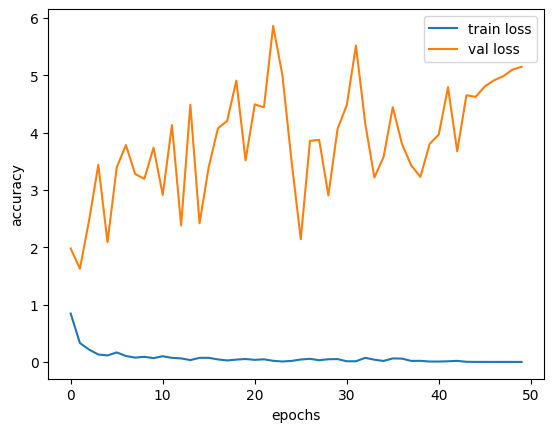

In [39]:
plt.plot(history_lstm.history['loss'], label='train loss')
plt.plot(history_lstm.history['val_loss'], label='val loss')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()
plt.show()

## CNN model 2

In [50]:
cnn_model =  tf.keras.Sequential([
    tf.keras.layers.Conv1D(256, 8,activation='relu', padding='same',input_shape=(40,1)),  # X_train.shape[1] = No. of Columns
    tf.keras.layers.Conv1D(256, 8, padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.MaxPooling1D(pool_size=(8)),
    tf.keras.layers.Conv1D(128, 8, padding='same'),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.Conv1D(128, 8, padding='same'),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.Conv1D(128, 8, padding='same'),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.Conv1D(128, 8, padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.MaxPooling1D(4),
    tf.keras.layers.Conv1D(64, 8, padding='same',activation='relu'),
    tf.keras.layers.Conv1D(64, 8, padding='same',activation='relu'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(7,activation='softmax')
])

In [51]:
cnn_model.compile(
    loss = 'categorical_crossentropy',
    optimizer = 'adam',
    metrics = ['accuracy']
)

In [52]:
history_cnn2 = cnn_model.fit(X,y_train,validation_split=0.2,epochs=150)

Epoch 1/150
70/70 [==============================] - 8s 81ms/step - loss: 1.0523 - accuracy: 0.6040 - val_loss: 0.9789 - val_accuracy: 0.6429
Epoch 2/150
70/70 [==============================] - 6s 83ms/step - loss: 0.2611 - accuracy: 0.9027 - val_loss: 1.2145 - val_accuracy: 0.6250
Epoch 3/150
70/70 [==============================] - 5s 76ms/step - loss: 0.1139 - accuracy: 0.9670 - val_loss: 0.7672 - val_accuracy: 0.7411
Epoch 4/150
70/70 [==============================] - 5s 77ms/step - loss: 0.0840 - accuracy: 0.9759 - val_loss: 1.3480 - val_accuracy: 0.6643
Epoch 5/150
70/70 [==============================] - 5s 78ms/step - loss: 0.0551 - accuracy: 0.9808 - val_loss: 1.2401 - val_accuracy: 0.6339
Epoch 6/150
70/70 [==============================] - 6s 85ms/step - loss: 0.0750 - accuracy: 0.9754 - val_loss: 1.0482 - val_accuracy: 0.6607
Epoch 7/150
70/70 [==============================] - 6s 83ms/step - loss: 0.0510 - accuracy: 0.9835 - val_loss: 1.5698 - val_accuracy: 0.6589
Epoch 

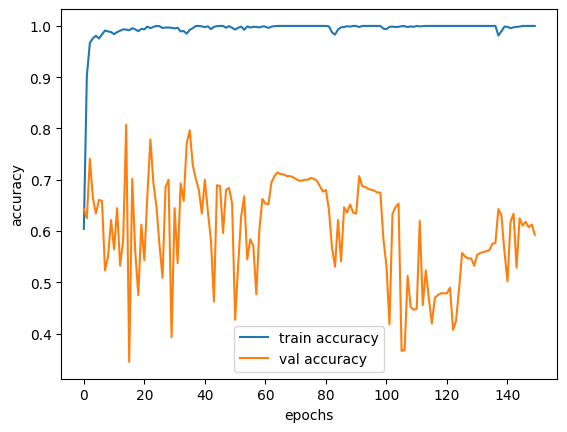

In [53]:
plt.plot(history_cnn2.history['accuracy'], label='train accuracy')
plt.plot(history_cnn2.history['val_accuracy'], label='val accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()
plt.show()

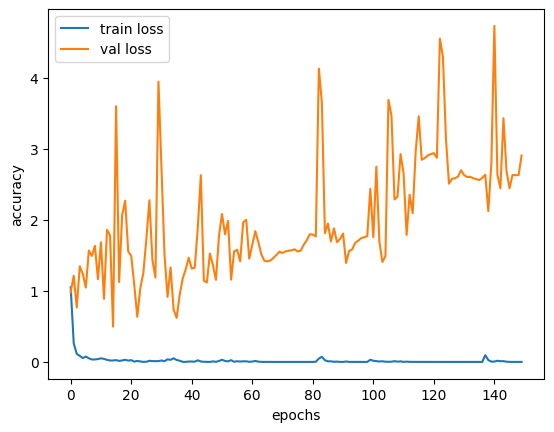

In [54]:
plt.plot(history_cnn2.history['loss'], label='train loss')
plt.plot(history_cnn2.history['val_loss'], label='val loss')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()
plt.show()